## Using N-Beats to Forecast Retail Data

https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting <br>

In [68]:
import os
import pandas as pd
import numpy as np

import matplotlib as mlab
import matplotlib.pyplot as plt
import seaborn as sns 

import io

import statsmodels.api as sm    
import scipy.stats as stats 
import math
import time
from pylab import rcParams

import sys
from functools import reduce

from datetime import date, timedelta
from pandas.tseries.offsets import Day, MonthBegin, MonthEnd
import itertools
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from google.colab import drive
from google.colab import files


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Conv1D,BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### Functions

In [69]:
# Generate training set with features and labels (from time series data)
def window_gen(x,window,horizon):
  x_t = []
  y_t = []
  # two years is 104 weeks
  for i in range(window,len(x)-horizon):
    x_t.append(x[i-window:i,0])
    y_t.append(x[i:i+horizon,0])
  return x_t,y_t

In [70]:
def dataset(x_train,y_train,x_valid,y_valid, batch):
  """
  take in arrays, output tensors. Original code sourced from 
  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb
  """
  train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
  train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

  test_features_dataset = tf.data.Dataset.from_tensor_slices(x_valid)
  test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_valid)

  train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
  test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

  train_dataset = train_dataset.batch(batch).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(batch).prefetch(tf.data.AUTOTUNE)

  return train_dataset, test_dataset

In [71]:
# Fill Function
def fill_blanks(df,srl_num,range,value_variable,date_variable):
  """
  fills missing observations. Naive approach - assumes missing data represent 0 sales.
  """
  stage_df = df.copy()
  for comb in stage_df[srl_num].unique(): 
    temp = stage_df[stage_df[srl_num] == comb].copy()
    stage_df = stage_df[stage_df[srl_num] != comb] # remove existing series detail
    temp2 = range.merge(temp,how='left',on=date_variable)
    # since we are filling missing data, other fields will be missing to
    # value info will be filled by zero, for other fields, we simply forward fill
    # Then back fill for full missing value coverage    
    temp2[value_variable].fillna(0,inplace=True)
    temp2.fillna(method='ffill',inplace=True)
    temp2.fillna(method='bfill',inplace=True)
    # replace with new, full data subset
    stage_df = stage_df.append(temp2,ignore_index=True)
  return stage_df

In [72]:
def change_shape(temp):
  temp = temp[['Weekly_Sales','Date']].copy()  # create single series dataframe
  y = temp.Weekly_Sales.values          # extract values
  y = y.reshape(y.shape[0],1)           # reshape
  return y

### Strategy
The entire dataset contains lots of features such as:
- Markdown
- Holidays
- CPI
- Fuel Price
- Plus much more <br>

For this exercise, we'll be considering only sales. So a univaritate multiseries approach. In a different notebook, I'll look at adding the full set of featues in a different notebook. <br>

**EDA** - *I will not be posting EDA here. You should defintely conduct eda, but the focus here is to look at the N-BEATS implementation.*

This notebooks looks exclusively at univariate (only past sales data) to forecast.

### Data Munging
The data 'pack' contains the following files:<br>
- **Train** - contains date, store, department, sales, holiday
- Features -  All dates (test + train), fuel price, Markdowns (multiple columns), CPI, unemployment, holiday
- Stores - Store number, size
- test - contains store, department, date

Again, we are only using 'Train' for this data exercise.

**Data Munging Steps**
1. Take in data 
2. Serialize data (create an id for each store, dept combination)
3. Split data set by 'forecastable' and not - Training data contain 143 weekly observations. Some store, dept combinations (series) however do not contain nearly enough (less that 52 weeks) of data to forecast. These series, will be thrown into a simple forecast set (simple_forecast). The forecast for these series will be a simple mean

In [73]:
uploaded = files.upload()

Saving train.csv to train (1).csv


In [76]:
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

#### Serialize the data<br>
This will allow us later to loop through ids to generate forecasts

In [85]:
# create a unique set of store, dept combinations, create a range
comb = df_train[['Store','Dept']].drop_duplicates().reset_index().copy()
comb['ts_id'] = pd.Series(range(comb.shape[0]))

In [86]:
# merge comb set with train
df_train = df_train.merge(comb.drop(['index'],axis=1),how='inner',on=['Store','Dept'])

In [11]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,ts_id
0,1,1,2010-02-05,24924.50,False,0
1,1,1,2010-02-12,46039.49,True,0
2,1,1,2010-02-19,41595.55,False,0
3,1,1,2010-02-26,19403.54,False,0
4,1,1,2010-03-05,21827.90,False,0


#### Split Forecast dataset <br>
- Remove series that don't have data for last 6 months
- Remove series that don't have at least 52 weeks of data

In [87]:
end_date = df_train.groupby('ts_id').Date.max().reset_index()

In [88]:
discard1 = end_date[end_date.Date < '2012-04-26']['ts_id'].values
df_train_trim = df_train[~df_train.ts_id.isin(discard1)]
# count # of observations by series
ts_data = df_train_trim.groupby('ts_id').agg({'Weekly_Sales':'count','Date':'max'}).reset_index()
ts_data.columns = ['ts_id','count','max_date']
ts_data.sort_values('count').head()

,ts_id,count,max_date
1158,1219,1,2012-07-06
1084,1143,1,2012-07-20
2556,2698,1,2012-08-17
2574,2717,1,2012-07-13
1232,1295,1,2012-10-05


In [89]:
discard2 =ts_data[ts_data['count'] < 52]['ts_id'].values

In [90]:
# second discard
df_train_trim = df_train_trim[~df_train_trim.ts_id.isin(discard2)]


In [91]:
#change 
df_train_trim.Date = pd.to_datetime(df_train_trim.Date)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [92]:
# ts_data = df_train_trim.groupby('ts_id').agg({'Weekly_Sales':'count','Date':'max'}).reset_index()
# ts_data.columns = ['ts_id','count','max_date']
# ts_data.sort_values('count').head()

In [93]:
# this list will be saved for latter. These series will be forecasted 
# with a very simple mean calculation
discard = np.append(discard1,discard2,axis=0)
simple_forecast = df_train[df_train.ts_id.isin(discard)]
simple_forecast.Date = pd.to_datetime(simple_forecast.Date)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [94]:
simple_forecast.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
ts_id                    int64
dtype: object

In [125]:
# Fill remaining dates with zeros
%%time
date_field = pd.date_range(start=df_train.Date.min(),end=df_train.Date.max(),closed=None,freq='W-FRI')
date_field = pd.DataFrame(date_field)
date_field.columns = ['Date']
df_ready = fill_blanks(df_train_trim,'ts_id',date_field,'Weekly_Sales','Date')

CPU times: user 1min 36s, sys: 2.76 s, total: 1min 38s
Wall time: 1min 33s


In [126]:
df_ready.ts_id.unique().shape

(2983,)

## Nbeats Implementation

### Model Configuration

In [127]:
# Create NBeatsBlock custom layer 
# for custom DNN, using tensorflow subclassing

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
#               theta_size: int = ,
               horizon: int,
               n_neurons: int,
               n_layers: int =4,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.horizon = horizon
    self.theta_size = self.input_size + self.horizon

    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(self.theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

**Training data for N-BEATS**<br>
 Setting up training data for a deep learning model is more involved. This is done by using a sliding window, with fixed segments for training and label data. The label data represents the forecast horizon. For this research I began by slicing each series which contained 143 observations into segments of 120, each with 80 observations for training and 40 for labels. This was a convenient split as the prediction horizon was 39.

![windowing](windowing.png)

In [128]:
window = 80
horizon = 40

In [129]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
epochs = 5000 # called "Iterations" in Table 18
neurons = 512 # called "Width" in Table 18
block_layers = 4
stacks = 30
batch = 1024

input_size = window # This should be a multiple of the horizon size.
theta_size = input_size + horizon

input_size, theta_size

(80, 120)

### Data Pipeline
1. For every series, there will be samples generated that include
- featuers of size window
- & labels of size horizon
2. Then, the sampled data recoreds will be split into training and validation.
3. Then grab the final 'window' number of samples (for example 80) and use this to make final prediction.<br>
  - make sure prediction dates match the expected date range on submission file.
4. Save this prediction   

![architecture](nbeats_architecture.png)

### Model Build out

In [130]:
%%time
def model_build():
  tf.random.set_seed(48)

  # Initialize N-BEATS Block layer [ block 1]
  nbeats_block_layer = NBeatsBlock(input_size=input_size,
                                  horizon=horizon,
                                  n_neurons=neurons,
                                  n_layers=block_layers,
                                  name="Block_1")

  # 2. Create input to stacks
  stack_input = layers.Input(shape=(input_size), name="stack_input")

  # 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
  backcast, forecast = nbeats_block_layer(stack_input)
  # Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
  residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

  # 4. Create stacks of blocks
  for i, _ in enumerate(range(stacks-1)): # generate all stacks after the first

    # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
    backcast, block_forecast = NBeatsBlock(
        input_size=input_size,
        horizon=horizon,
        n_neurons=neurons,
        n_layers=block_layers,
        name=f"NBeatsBlock_{i}"
    )(residuals) 

    # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")
  return nbeats_block_layer, stack_input, backcast, forecast,residuals

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [131]:
nbeats_block_layer, stack_input, backcast, forecast,residuals = model_build()

### Data Build

In [132]:
def data_build():
  x, y = [],[]
  ffeat = dict()  # final prediction features

  for series in df_ready.ts_id.unique():
    eval = []
    temp = df_ready[df_ready.ts_id == series].copy()
    ser = change_shape(temp)
    #ser_scaled = scaler.fit_transform(ser) 
    ffeat[series] = ser[-window:]
    #ser_scaled[-window:] # this wil be theseries to make final predictions
    # create two sets of x and y. THe second will be used to generate the true 
    # values to calculate MAE
    ## check if first series, if not append.
    if len(x) > 0: # check only scaled, assume it same for both
      #x_temp_scaled, y_temp_scaled = window_gen(ser_scaled,window,horizon)
      x_temp, y_temp = window_gen(ser,window,horizon)
      # non scaled arrays
      for x_array in x_temp:
        x.append(x_array)
      for y_array in y_temp:
        y.append(y_array)
    else: 
      x, y = window_gen(ser,window,horizon)
  return x,y,ffeat

In [133]:
x,y,ffeat = data_build()

In [134]:
len(x)

68609

In [135]:
def data_split():
  split_size = int(len(x) * 0.8)
  # x_train, y_train = x_scaled[:split_size], y_scaled[:split_size]
  # x_valid, y_valid = x_scaled[split_size:], y_scaled[split_size:]
  x_train, y_train = x[:split_size], y[:split_size]
  x_valid, y_valid = x[split_size:], y[split_size:]

  # line below is redudant, but keeping it to not change references
  x_valid_true, y_valid_true = x[split_size:], y[split_size:]
  train_ds,valid_ds =  dataset(x_train,y_train,x_valid,y_valid,batch)
  return train_ds,valid_ds, y_valid_true

In [136]:
train_ds,valid_ds, y_valid_true = data_split()

In [137]:
def model_create():
  # Put the stack model together
  model = tf.keras.Model(inputs=stack_input, 
                        outputs=forecast, 
                        name="model_N-BEATS")

  # 8. Compile with MAE loss and Adam optimizer
  model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])
  return model

In [138]:
model = model_create()

### Model fit

In [139]:
%%time
history = model.fit(train_ds,
            epochs=epochs,
            validation_data=valid_ds,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True) 
              ,tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)
                      ])


Epoch 00142: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00265: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00365: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 15min 27s, sys: 16.4 s, total: 15min 43s
Wall time: 17min 45s


**Performance**

In [140]:
metrics = model.evaluate(valid_ds)

14/14 [==============================] - 0s 20ms/step - loss: 1013.5490 - mae: 1013.5490 - mse: 4946314.5000


In [141]:
val_pred = model.predict(valid_ds)
#val_pred = scaler.inverse_transform(val_pred)

In [142]:
# builds the array for true values
%%time 
empty = 1
for array in y_valid_true:
  if empty == 1:
    Y_true = array.reshape(1,array.shape[0]).copy()
    empty = 0
  else:
    Y_true = np.append(Y_true,array.reshape(1,array.shape[0]),axis=0)

CPU times: user 4 s, sys: 218 ms, total: 4.22 s
Wall time: 4.2 s


**Validation MAE**
This is for validation set. So there will be 5 validation examples per series. There fore we will take the entire matrix of actual observations and compare to matrix of same size of predictions.

In [143]:
#This is the weighte MAE for validation data 
np.absolute(Y_true - val_pred).mean()

1013.5488527608821

In [145]:
#losses = history.history['loss']
mae = history.history['mae']
#val_losses = history.history['val_loss']
val_mae = history.history['val_mae']
epochs = len(mae)

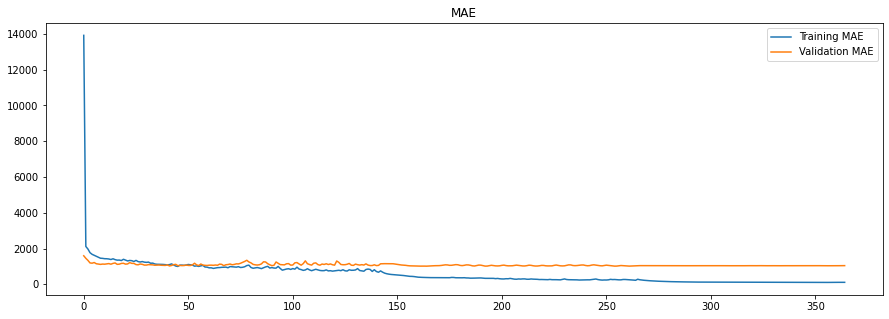

In [148]:
fig = plt.figure(figsize=(15, 5))
ax2 = fig.add_subplot()
ax2.plot(range(epochs), mae, label='Training MAE')
ax2.plot(range(epochs), val_mae, label='Validation MAE')
ax2.set_title('MAE')
ax2.legend()
plt.show()

### Generate Final Prediction File

There are 3 steps to this process:<br>
1. Put prediction from N-BEATS model in to a dataframe
2. Make a simple prediction for simple_forecast data frame
3. Identify stores/dept combinations in test dataset, not in training*

**There area series in the test data that are not in training. For this excercise we are setting these prediction to 0. Likely a better approach is to use a imputation methodology to estimate those sales.*

**Upload Test Prediction File**

In [151]:
uploaded = files.upload()

Saving test.csv to test.csv


In [152]:
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [195]:
df_test.Date = pd.to_datetime(df_test.Date)

In [153]:
date_series = pd.date_range(start=df_ready.Date.max(),periods=40,freq='W-FRI',closed='right')

In [154]:
%%time
temp = []
for key in ffeat:
  # if key > 5:
  #   break
  #print('key is',key)
  test = ffeat[key]
  test = test.reshape(1,test.shape[0],1)
  pred = model.predict(test)
#  pred = scaler.inverse_transform(pred)
  pred = pred[:,:39][0]
  store = df_ready[df_ready.ts_id == key].iloc[:39,0]
  dpt = df_ready[df_ready.ts_id == key].iloc[:39,1]
  holiday = df_test[['Date','IsHoliday']].drop_duplicates().sort_values('Date')['IsHoliday']
  for i in range(39):
    temp.append({'Store':store.iloc[i],'Dept':dpt.iloc[i],'Date':date_series[i],'IsHoliday':holiday.iloc[i],'Weekly_Sales':pred[i]})

CPU times: user 2min 50s, sys: 6.34 s, total: 2min 56s
Wall time: 2min 46s


**Put into required format**

In [156]:
df_pred1 = pd.DataFrame(temp)

**Handle simple forecast**

In [157]:
fcast_array = simple_forecast.groupby('ts_id').Weekly_Sales.mean().reset_index()

In [158]:
fcast_array.head()

,ts_id,Weekly_Sales
0,43,-116.454545
1,46,32.712727
2,58,677.000000
3,59,11.500000
4,76,306.091081


There are some negative numbers. We need to clip these values

In [159]:
#clip sales at 0 
fcast_array.Weekly_Sales = np.clip(fcast_array.Weekly_Sales,a_min = 0,a_max=None)

In [175]:
simple_forecast.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,ts_id
6047,1,47,2010-02-05,70.0,False,43
6048,1,47,2010-02-19,-863.0,False,43
6049,1,47,2010-03-12,-698.0,False,43
6050,1,47,2010-04-09,14.0,False,43
6051,1,47,2010-10-08,-58.0,False,43


In [176]:
fcast_array.head()

,ts_id,Weekly_Sales
0,43,0.000000
1,46,32.712727
2,58,677.000000
3,59,11.500000
4,76,306.091081


In [181]:
#for id in fcast_array.ts_id.unique():
temp = []
holiday = df_test[['Date','IsHoliday']].drop_duplicates().sort_values('Date')['IsHoliday']
for row in fcast_array.iterrows():
    store = simple_forecast[simple_forecast.ts_id == row[1][0]].iloc[0,0]
    dpt = simple_forecast[simple_forecast.ts_id == row[1][0]].iloc[0,1]
    pred = row[1][1]
    for i in range(39):
        temp.append({'Store':store,'Dept':dpt,'Date':date_series[i],'IsHoliday':holiday.iloc[i],'Weekly_Sales':pred})

In [182]:
simple = pd.DataFrame(temp)

**Identify Series not in training**<br>
set these to zero for forecast

In [184]:
training_set = df_train[['Store','Dept']].drop_duplicates().sort_values(by=['Store','Dept'])
df_all = df_test.merge(training_set, on=['Store','Dept'], how='left', indicator=True)

In [188]:
crap_series = df_all[df_all._merge == 'left_only'][['Store','Dept']].drop_duplicates()

In [189]:
#for id in fcast_array.ts_id.unique():
temp = []
holiday = df_test[['Date','IsHoliday']].drop_duplicates().sort_values('Date')['IsHoliday']
for row in crap_series.iterrows():
    store = row[1][0]
    dpt = row[1][1]
    pred = 0
    for i in range(39):
        temp.append({'Store':store,'Dept':dpt,'Date':date_series[i],'IsHoliday':holiday.iloc[i],'Weekly_Sales':pred})

In [190]:
crap = pd.DataFrame(temp)

**Combine Data**

In [196]:
dft = df_test[['Store','Dept','Date']]
df_pred = df_pred1.merge(dft,how='inner',on=['Store','Dept','Date'])

simple_forecast = simple_forecast.merge(dft,how='inner',on=['Store','Dept','Date'])
crap = crap.merge(dft,how='inner',on=['Store','Dept','Date'])

df_pred_new = pd.concat([df_pred,simple_forecast,crap],ignore_index=True)

In [206]:
df_pred_new.Store = df_pred_new.Store.astype(int)
df_pred_new.Dept = df_pred_new.Dept.astype(int)

In [207]:
temp = []
for row in df_pred_new.iterrows():
    id = str(row[1][0])+'_'+str(row[1][1])+'_'+str(row[1][2])[:10]
    pred = row[1][4]
    temp.append({'Id':id,'Weekly_Sales':pred})

In [208]:
final_submission = pd.DataFrame(temp)

In [209]:
final_submission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,25379.138672
1,1_1_2012-11-09,19420.230469
2,1_1_2012-11-16,17355.078125
3,1_1_2012-11-23,21758.083984
4,1_1_2012-11-30,20395.638672
